In [ ]:
!pip install -r requirements.txt

In [1]:
# import packages

import glob
import os
import itertools
import umap
import hdbscan

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Masking

In [2]:
# setting working directory

work_dir = 'D:/Lab/Jordan lab/projects/2022_Zambia/1_contest_trial/analysis'

In [3]:
# Setting keypoints

keypoint_names = ['mouth', 'head', 'dorsal_front', 'dorsal_center', 'dorsal_back', 'caudal_fin']

key_characters = [f'distance_{keypoint_names[1]}-{keypoint_names[1]}',
                  f'alignment_{keypoint_names[1]}-{keypoint_names[0]}',
                  f'alignment_{keypoint_names[4]}-{keypoint_names[3]}',
                  f'angles_{keypoint_names[1]}-{keypoint_names[0]} to {keypoint_names[1]}',
                  f'angles_{keypoint_names[4]}-{keypoint_names[3]} to {keypoint_names[1]}',
                  f'angles_{keypoint_names[1]}-{keypoint_names[0]} to {keypoint_names[4]}',
                  f'angles_{keypoint_names[4]}-{keypoint_names[3]} to {keypoint_names[4]}']

key_characters

['distance_head-head',
 'alignment_head-mouth',
 'alignment_dorsal_back-dorsal_center',
 'angles_head-mouth to head',
 'angles_dorsal_back-dorsal_center to head',
 'angles_head-mouth to dorsal_back',
 'angles_dorsal_back-dorsal_center to dorsal_back']

In [4]:
# import sampled frames with key characters
## key characters were already calculated from raw tracking data
sampled_df = pd.read_csv(work_dir + '/umap_embedding/22Mar23/sampled_umap_cluster.csv')

## extract train_data with UMAP-HDBSCAN clustering ids (umap_neighbor == 15)

train_data = sampled_df[key_characters].to_numpy()
train_label = sampled_df['cluster_un15'].to_numpy()

## standardize the train data

scaler = StandardScaler().fit(train_data)
train_data = scaler.transform(train_data)

In [5]:
# create umap model

umap_train = umap.UMAP(n_neighbors=15, random_state=0).fit(train_data)
train_data = umap_train.embedding_

In [6]:
# visualize umap embedding of key characters of frames with HDBSCAN clustering resutls
## HDBSCAN clustering is only for visualization, not used for further steps

def umap_figure(embedding):
    e_max = np.amax(embedding, axis=0)
    e_min = np.amin(embedding, axis=0)
    
    # assign colors to time windows by the distance from the origin
    dist_colors = [((x[0] - e_min[0])/(e_max[0] - e_min[0]), 
                    (x[1] - e_min[1])/(e_max[1] - e_min[1]), 
                    0.5) for x in embedding]
    
    # plot UMAP latent projection without clustering
    plt.scatter(embedding[:, 0], embedding[:, 1], c=dist_colors, s=0.1)
    plt.gca().set_aspect('equal', 'datalim')
    plt.show()

def hdbscan_figure(embedding, cluster_labels):
    # assign colors to time windows by the clustering results
    color_palette = sns.color_palette('tab10')
    cluster_colors = np.array([color_palette[x] if x >= 0
                               else (0.5, 0.5, 0.5)
                               for x in cluster_labels])
    
    ### plot UMAP latent projection with clustering results
    #### general figure
    fig, ax = plt.subplots()
    ax.scatter(embedding[:, 0], embedding[:, 1], c=cluster_colors, s=0.1)
    plt.gca().set_aspect('equal', 'datalim')
    plt.show()

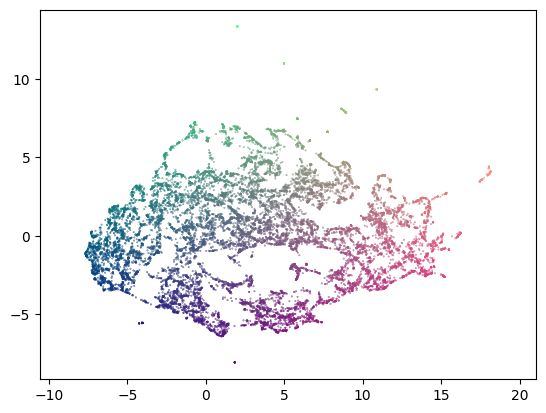

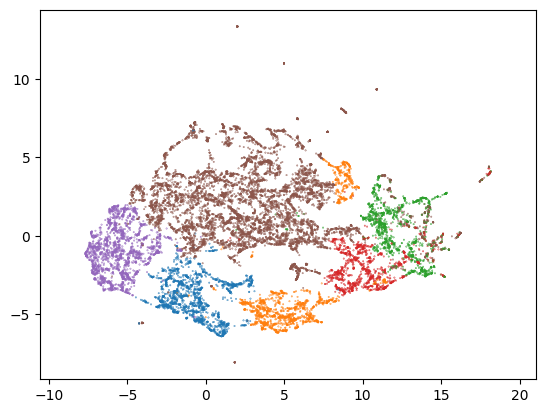

In [7]:
## UMAP embedding without clustering results
umap_figure(train_data)

## UMAP embedding with HDBSCAN clustering results
hdbscan_figure(train_data, train_label)

In [ ]:
## examples of pose clusters


In [11]:
# import time stamps for pre-classified behaviors
## example_motion_class.csv includes time stamps of lateral display and bite behavior

time_stamp_df = pd.read_csv(work_dir + '/example_motion_class/example_motion_class.csv')

trial_path = os.path.join(work_dir+'/csv/multi_*.csv')
trial_ls = glob.glob(os.path.normpath(trial_path))

In [13]:
# create input data for training LSTM autoencoder

pd.options.mode.chained_assignment = None

max_seq_len = 0
raw_behav_seq = []
true_labels = []
for trial in trial_ls:
    ## import feature and time_stamp dataframes
    trial_df = pd.read_csv(trial)
    trial_name = trial.split('\\')[-1][:-12]
    print(trial_name)
    
    file_time_stamp = time_stamp_df[time_stamp_df['file']==trial_name]
    if len(file_time_stamp) == 0:
        print('No data!')
        continue
    
    trial_df_labeled = pd.DataFrame()
    for index, row in file_time_stamp.iterrows():
        
        ## calculate start & end frames of each behavior
        ### raw videos were divided into three files due to the camera setting
        ### each file has 63660 frames
        part = int(row['part'])-1 
        bout_start = row['start'] + (part*63660) 
        bout_end = row['end'] + (part*63660) 
        
        ## save true labels
        bout_class = row['class']
        true_labels.append(bout_class)
        
        ## transform key characters of each behaviors into umap embedding
        bout_df = trial_df[(trial_df['time_stamp'] >= bout_start) & (trial_df['time_stamp'] <= bout_end)]
        bout_feature = bout_df[key_characters].to_numpy()
        bout_feature = scaler.transform(bout_feature)
        bout_umap = umap_train.transform(bout_feature)
        
        ## upadate max_seq_len for zero-padding
        if bout_umap.shape[0] > max_seq_len:
            max_seq_len = bout_umap.shape[0]
        
        raw_behav_seq.append(bout_umap)

multi_contest_trial1_boxE_06Nov22
No data!
multi_contest_trial1_boxE_20Oct22
multi_contest_trial1_boxE_22Oct22
No data!
multi_contest_trial1_boxE_23Oct22
No data!
multi_contest_trial1_boxE_31Oct22
No data!
multi_contest_trial1_boxF_06Nov22
No data!
multi_contest_trial1_boxF_20Oct22
No data!
multi_contest_trial1_boxF_22Oct22
No data!
multi_contest_trial2_boxE_06Nov22
No data!
multi_contest_trial2_boxE_20Oct22
No data!
multi_contest_trial2_boxE_22Oct22
No data!
multi_contest_trial2_boxE_23Oct22
multi_contest_trial2_boxE_31Oct22
No data!
multi_contest_trial2_boxF_06Nov22
No data!
multi_contest_trial2_boxF_20Oct22
No data!
multi_contest_trial3_boxE_06Nov22
No data!
multi_contest_trial3_boxE_20Oct22
multi_contest_trial3_boxE_22Oct22
No data!
multi_contest_trial3_boxE_23Oct22
No data!
multi_contest_trial3_boxE_31Oct22
No data!
multi_contest_trial3_boxF_06Nov22
No data!
multi_contest_trial4_boxE_06Nov22
No data!
multi_contest_trial4_boxE_22Oct22
No data!
multi_contest_trial4_boxE_23Oct22
No d

In [15]:
## zero-padding to max_seq_len

input_seq = []
for indiv_seq in raw_behav_seq:
    indiv_seq = np.array(indiv_seq)
    pad_width_0 = (max_seq_len-indiv_seq.shape[0])//2
    pad_width_1 = (max_seq_len-indiv_seq.shape[0]) - pad_width_0
    indiv_seq_pad = np.pad(indiv_seq, ((pad_width_0, pad_width_1),(0, 0)))
    input_seq.append(indiv_seq_pad)
    
input_seq = np.array(input_seq)

input_seq.shape

(15, 324, 2)

In [16]:
# train LSTM autoencoder
## setting parameters

LEARNING_RATE = 0.0005
BATCH_SIZE = 16
EPOCHS = 50

In [17]:
def train(x_train, learning_rate, batch_size, epochs):
    # define model
    model = Sequential()
    model.add(Masking(mask_value=0, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(100, activation='tanh'))
    model.add(RepeatVector(x_train.shape[1]))
    model.add(LSTM(100, activation='tanh', return_sequences=True))
    model.add(TimeDistributed(Dense(x_train.shape[2])))
    model.summary()
    
    # compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    # train_model
    model.fit(x_train, x_train, batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=True)
    
    # separate encoder & decoder
    ## encoder
    Encoder = Model(inputs=model.inputs, outputs=model.layers[1].output)
    ## decoder
    encoded_input = tf.keras.Input(shape=(100,))
    decoded = model.layers[2](encoded_input)
    decoded = model.layers[3](decoded)
    decoded = model.layers[4](decoded)
    Decoder = Model(encoded_input, decoded)
    
    return model, Encoder, Decoder

In [18]:
## train LSTM autoencoder
Autoencoder, Encoder, Decoder = train(input_seq, LEARNING_RATE, BATCH_SIZE, EPOCHS)

## get latent_representation of input sequences
latent_representation = Encoder.predict(input_seq)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 324, 2)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               41200     
                                                                 
 repeat_vector (RepeatVector  (None, 324, 100)         0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 324, 100)          80400     
                                                                 
 time_distributed (TimeDistr  (None, 324, 2)           202       
 ibuted)                                                         
                                                                 
Total params: 121,802
Trainable params: 121,802
Non-trai

In [19]:
def LSTM_umap_figure(embedding):
    e_max = np.amax(embedding, axis=0)
    e_min = np.amin(embedding, axis=0)
    
    # assign colors to time windows by the distance from the origin
    dist_colors = [((x[0] - e_min[0])/(e_max[0] - e_min[0]), 
                    (x[1] - e_min[1])/(e_max[1] - e_min[1]), 
                    0.5) for x in embedding]
    
    # plot UMAP latent projection without clustering
    plt.scatter(embedding[:, 0], embedding[:, 1], c=dist_colors)
    plt.gca().set_aspect('equal', 'datalim')
    plt.show()
    plt.close()
    
def LSTM_hdbscan_figure(embedding, cluster_lables, true_labels):
    # assign colors to time windows by the clustering results
    color_palette = sns.color_palette('tab10')
    cluster_colors = np.array([color_palette[x] if x >= 0
                               else (0.5, 0.5, 0.5)
                               for x in cluster_labels])
    
    ## plot UMAP latent projection with clustering results
    true_label_unique = list(set(true_labels))
    n_true_label = len(true_label_unique)
    markers = ["o", "x", "^", "s", "*"]
    
    fig, ax = plt.subplots()
    for i in range(n_true_label):
        label_idx = [idx for idx, e in enumerate(true_labels) if e == true_label_unique[i]]
        
        x = embedding[:, 0][label_idx]
        y = embedding[:, 1][label_idx]
        color = cluster_colors[label_idx]
        
        ax.scatter(x, y, c=color, marker=markers[i])
    
    f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

    handles = [f("s", cluster_colors[i]) for i in range(2)]
    handles += [f(markers[i], "k") for i in range(2)]
    
    labels = list(set(cluster_labels)) + true_label_unique
    
    plt.legend(handles, labels, loc = 'upper right')
    plt.gca().set_aspect('equal', 'datalim')
    plt.show()
    plt.close()

Results with umap_neighbor = 5


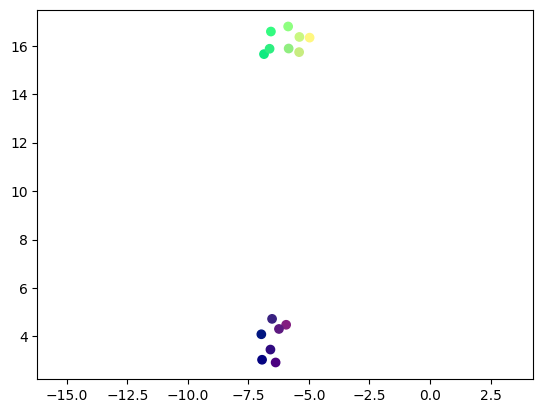

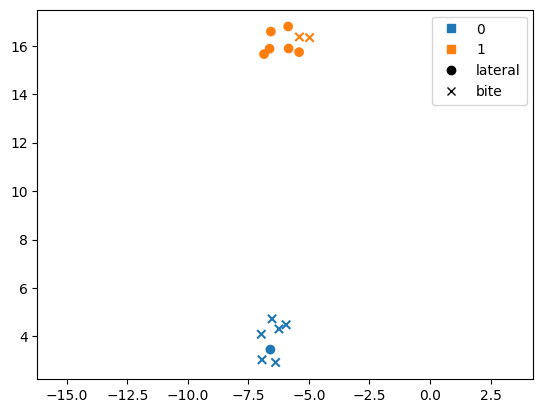

Results with umap_neighbor = 10


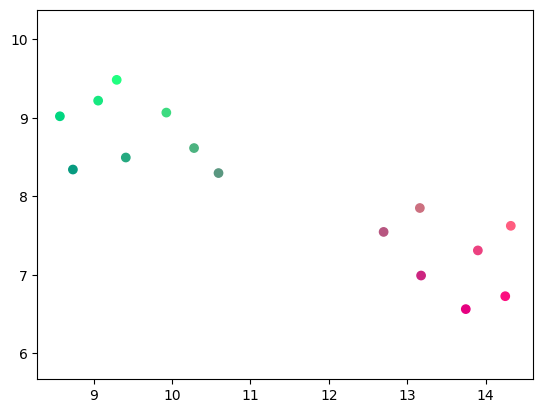

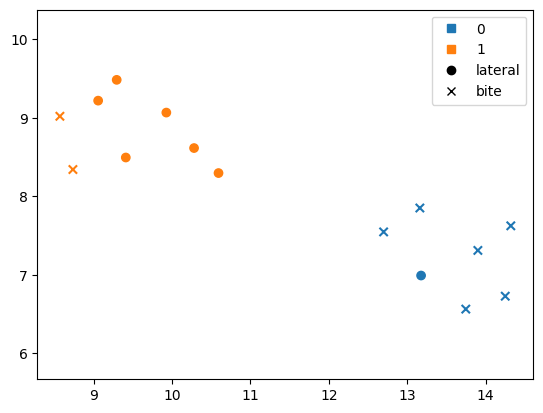

In [21]:
# HDBSCAN clustering of latent representations

umap_neighbor = [5, 10]
for neighbor in umap_neighbor:
    print(f"Results with umap_neighbor = {neighbor}")
    ## UMAP with latent representation
    reducer = umap.UMAP(random_state=0, n_neighbors=neighbor).fit(latent_representation)
    second_embedding = reducer.transform(latent_representation)
    ### visualize umap embedding of LSTM latent representation
    LSTM_umap_figure(second_embedding)
    
    ## HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)
    clusterer.fit(second_embedding)
    cluster_labels = clusterer.labels_
    ### visualize HDBSCAN clustering
    LSTM_hdbscan_figure(second_embedding, cluster_labels, true_labels)

In [ ]:
# The results can be improved by 
# adding more key characters, changing hyperparamters for UMAP, HDBSCAN, or LSTM autoencoder, etc.